In [66]:
from functools import partial
from typing import Callable, Dict, Generator, List, Tuple

from datasets import load_dataset
import numpy as np
from sklearn.utils import shuffle
import torch
from torch import nn
from torchtext.vocab import vocab, Vocab
from torchtext.data.utils import get_tokenizer

from tqdm.auto import tqdm

In [67]:
dataset = load_dataset("imdb")
train_dataset = dataset["train"].train_test_split(
    stratify_by_column="label", test_size=0.2, seed=42
)
test_df = dataset["test"]
train_df = train_dataset["train"]
valid_df = train_dataset["test"]
train_df.shape, valid_df.shape, test_df.shape

Found cached dataset imdb (C:/Users/theot/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)
100%|██████████| 3/3 [00:00<00:00, 11.24it/s]
Loading cached split indices for dataset at C:\Users\theot\.cache\huggingface\datasets\imdb\plain_text\1.0.0\d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0\cache-5f37fd0866e4f89f.arrow and C:\Users\theot\.cache\huggingface\datasets\imdb\plain_text\1.0.0\d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0\cache-dd5732a0e6ac784c.arrow


((20000, 2), (5000, 2), (25000, 2))

# Vocabulary

In [68]:
from collections import Counter

tokenizer = get_tokenizer("basic_english", language="en")
counter = Counter()

def lowercase_punctuation(text):
    newtext = text.lower()
    # remove <br /> tags
    newtext = newtext.replace('<br />', '')
    # remove punctuation
    newtext = ''.join([c if c not in "\"#$%&()*+,./:;<=>?@[\]^_`{|}~" else ' ' for c in newtext])
    return newtext


for row in train_df:
    counter.update(tokenizer(lowercase_punctuation(row['text'])))

# Set the minimum frequency threshold to eliminate noise
min_freq = 2

# Include special tokens
specials = ['<unk>', '<pad>']

# Create the vocabulary
vocab = vocab(counter, min_freq=min_freq, specials=specials)

# Vectorizer

In [69]:
def vectorize_text(text: str, vocabulary: Vocab, tokenizer: Callable[[str], List[str]]) -> torch.Tensor:
    """
    Generate a tensor of vocabluary IDs for a given text.
    Args:
        text: the input text.
        vocabulary: a Vocab objects.
        tokenizer: a text tokenizer.
    Returns:
        A tensor of IDs (torch.long).
    """
    text = lowercase_punctuation(text)
    tokens = tokenizer(text)
    vocab_stoi = vocabulary.get_stoi()
    token_ids = []
    for token in tokens:
        if token in vocab_stoi:
            token_ids.append(torch.tensor(vocab_stoi[token]))
        else:
            token_ids.append(torch.tensor(vocab_stoi['<unk>']))
    return torch.stack(token_ids)
            
text_pipeline = partial(vectorize_text, vocabulary=vocab, tokenizer=tokenizer)


Petit test : 

In [70]:
text_pipeline("Some text I am thinking about... ragafqfa")

tensor([  36, 5526,   11,  273,  665,    8,    0])

In [71]:
X_train = [text_pipeline(text) for text in tqdm(train_df["text"])]
y_train = train_df["label"]
X_valid = [text_pipeline(text) for text in tqdm(valid_df["text"])]
y_valid = valid_df["label"]
X_test = [text_pipeline(text) for text in tqdm(test_df["text"])]
y_test = test_df["label"]

100%|██████████| 25000/25000 [18:11<00:00, 22.90it/s]


# Data generator

In [73]:
def data_generator(
    X: List[torch.tensor], y: List[int], pad_id: int, batch_size: int = 32
) -> Generator[Tuple[torch.Tensor, torch.Tensor], None, None]:
    """
    Yield batches from given input data and labels.
    Args:
        X: a list of tensor (input features).
        y: the corresponding labels.
        pad_id: the padding id.
        batch_size: the size of every batch [32].
    Returns:
        A tuple of tensors (features, labels).
    """
    num_samples = len(X)
    num_batches = num_samples // batch_size

    # Iterate over each batch
    for i in range(num_batches):
        start = i * batch_size
        end = start + batch_size

        # Get the batch data and labels
        batch_X = X[start:end]
        batch_y = y[start:end]

        # Find the length of the longest sequence in this batch
        max_length = max([len(tensor) for tensor in batch_X])

        # Create a new list to hold the padded sequences
        padded_batch_X = []

        # Pad each sequence to the length of the longest sequence
        for tensor in batch_X:
            num_padding = max_length - len(tensor)
            padded_tensor = torch.cat([tensor, torch.full((num_padding,), pad_id, dtype=torch.long)])
            padded_batch_X.append(padded_tensor)

        # Convert the lists to tensors
        batch_X_tensor = torch.stack(padded_batch_X)
        batch_y_tensor = torch.tensor(batch_y, dtype=torch.long)

        yield batch_X_tensor, batch_y_tensor

In [74]:
pad_token_id = vocab['<pad>']
train_gen = lambda: data_generator(X_train, y_train, pad_token_id)
valid_gen = lambda: data_generator(X_valid, y_valid, pad_token_id)
test_gen = lambda: data_generator(X_test, y_test, pad_token_id)

# Part 1 : RNN From Scratch

In [138]:
class RNN:
    def __init__(self, vocab_size, embedding_size, hidden_size):
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        
        # Initialisation des poids
        self.W = np.random.randn(vocab_size, embedding_size)
        self.U = np.random.randn(hidden_size, hidden_size)
        self.V = np.random.randn(hidden_size, 1)
        
        # Initialisation de l'état caché
        self.h = np.zeros((hidden_size, 1))
    
    def forward(self, x):
        embedded = self.embedding(x)
        h_t = np.tanh(np.dot(embedded, self.W) + np.dot(self.h, self.U))
        y_pred = np.dot(h_t, self.V)
        return y_pred.squeeze()
    
    def embedding(self, x):
        embedded = np.zeros((len(x), self.embedding_size))
        for i, idx in enumerate(x):
            embedded[i] = np.eye(self.vocab_size)[idx]
        return embedded
    
    def init_hidden(self):
        self.h = np.zeros((self.hidden_size, 1))

In [97]:
def mse_loss(y_pred, y_true):
    return np.mean((y_pred - y_true) ** 2)

def train_rnn(model, X_train, y_train, X_valid, y_valid, learning_rate, num_epochs):
    train_losses = []
    valid_losses = []

    for epoch in range(num_epochs):
        total_loss = 0
        for i, x in enumerate(X_train):
            model.init_hidden()

            # Forward pass
            y_pred = model.forward(x)

            # Compute loss
            loss = mse_loss(y_pred, y_train[i])
            total_loss += loss

            # Backpropagation
            dL_dy = 2 * (y_pred - y_train[i])
            dL_dV = np.dot(model.h.T, dL_dy)
            dL_dh_t = np.dot(dL_dy, model.V.T)

            dL_dW = np.dot(model.embedding(x).T, np.dot((1 - model.h ** 2) * dL_dh_t, model.U.T))
            dL_dU = np.dot(model.h.T, np.dot((1 - model.h ** 2) * dL_dh_t, model.U.T))

            # Update parameters
            model.W -= learning_rate * dL_dW
            model.U -= learning_rate * dL_dU
            model.V -= learning_rate * dL_dV

        avg_loss = total_loss / len(X_train)
        train_losses.append(avg_loss)

        # Evaluate on validation set
        valid_loss = 0
        for i, x in enumerate(X_valid):
            model.init_hidden()
            y_pred = model.forward(x)
            valid_loss += mse_loss(y_pred, y_valid[i])

        avg_valid_loss = valid_loss / len(X_valid)
        valid_losses.append(avg_valid_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_loss}, Valid Loss: {avg_valid_loss}")

    return train_losses, valid_losses


In [98]:
import matplotlib.pyplot as plt

model = RNN(vocab_size=len(vocab), embedding_size=100, hidden_size=128)
train_losses, valid_losses = train_rnn(model, X_train, y_train, X_valid, y_valid, learning_rate=0.01, num_epochs=10)


plt.plot(train_losses, label="Train Loss")
plt.plot(valid_losses, label="Valid Loss")
plt.legend()
plt.show()


ValueError: could not broadcast input array from shape (46146,) into shape (100,)

# PART 2 : RNN AVEC TORCH

La classe :

In [139]:
class RNN(nn.Module):
    """A simple RNN module with word embeddings.
    """
    def __init__(self, vocab_size: int, embed_size: int, hidden_size: int, n_layers: int, n_outputs: int) -> None:
        """
        Args:
            vocab_size: vocabulary size.
            embed_size: embedding dimensions.
            hidden_size: hidden layer size.
            n_layers: the number of layers.
            n_outputs: the number of output classes.
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_outputs = n_outputs


        # The word embedding layer.
        self.embed = nn.Embedding(self.vocab_size, self.embed_size)
        # The RNN
        self.rnn = nn.RNN(
            input_size = self.embed_size,
            hidden_size = self.hidden_size,
            num_layers = self.n_layers,
            batch_first = True, # Changes the order of dimension to put the batches first.
        )
        # A fully connected layer to project the RNN's output to only one output used for classification.
        self.fc = nn.Linear(self.hidden_size, self.n_outputs)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Function called when the model is called with data as input.
        Args:
            X: the input tensor of dimensions batch_size, sequence length, vocab size (actually just an int).
        Returns:
            The resulting tensor of dimension batch_size, sequence length, output dimensions.
        """
        h0 = torch.zeros(self.n_layers, X.size(0), self.hidden_size).to(device)

        out = self.embed(X)
        # out contains the output layer of all words in the sequence.
        # First dim is batch, second the word in the sequence, third is the vector itself.
        # The second output value is the last vector of all intermediate layer.
        # Only use it if you want to access the intermediate layer values of a
        # multilayer model.
        out, _ = self.rnn(out, h0)
        # Getting the last value only.
        out = out[:, -1, :]
    
        # Linear projection.
        out = self.fc(out)

        return out

La fonction d'entrainement :

In [150]:
def train(
    model: nn.Module,
    criterion: Callable,
    optimizer: torch.optim.Optimizer,
    n_epochs: int,
    train_gen: Callable,
    valid_gen: Callable,
) -> Tuple[nn.Module, List[float], List[float]]:
    """Train a model using a batch gradient descent.
    Args:
        model: a class inheriting from nn.Module.
        criterion: a loss criterion.
        optimizer: an optimizer (e.g. Adam, RMSprop, ...).
        n_epochs: the number of training epochs.
        train_gen: a callable function returning a batch (data, labels).
        valid_gen: a callable function returning a batch (data, labels).
        device: the device to use for computation.
    Returns:
        A tuple: [best_model (by validation loss), training losses, validation losses].
    """
    train_losses = []
    valid_losses = []
    best_valid_loss = float('inf')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for epoch in range(n_epochs):
        # Training Phase 
        model.train()
        train_loss = 0
        num_batches = 0  # counter to keep track of number of batches
        for X, y in train_gen():
            X, y = X.to(device), y.to(device).unsqueeze(1).float()
            optimizer.zero_grad()
            output = model(X)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= num_batches if num_batches > 0 else 1
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        valid_loss = 0
        with torch.no_grad():
            for X, y in valid_gen():
                X, y = X.to(device), y.to(device).unsqueeze(1).float()
                output = model(X)
                loss = criterion(output, y)
                valid_loss += loss.item()
        
        valid_loss /= num_batches if num_batches > 0 else 1
        valid_losses.append(valid_loss)

        # check if current validation loss is better (lower) than the previous best one
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_model = model

        print(f'Epoch: {epoch+1}/{n_epochs}.. Training Loss: {train_loss:.3f}.. Validation Loss: {valid_loss:.3f}')

    return best_model, train_losses, valid_losses

In [151]:
#train
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RNN(len(vocab), 32, 64, 1, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())
best_model, train_losses, valid_losses = train(model, criterion, optimizer, 20, train_gen, valid_gen)

Epoch: 1/20.. Training Loss: 434.389.. Validation Loss: 108.706
Epoch: 2/20.. Training Loss: 433.177.. Validation Loss: 108.683
Epoch: 3/20.. Training Loss: 432.907.. Validation Loss: 108.897
Epoch: 4/20.. Training Loss: 431.994.. Validation Loss: 109.085
Epoch: 5/20.. Training Loss: 430.541.. Validation Loss: 109.197
Epoch: 6/20.. Training Loss: 428.366.. Validation Loss: 109.508
Epoch: 7/20.. Training Loss: 434.095.. Validation Loss: 108.849
Epoch: 8/20.. Training Loss: 432.090.. Validation Loss: 108.972
Epoch: 9/20.. Training Loss: 432.104.. Validation Loss: 108.736
Epoch: 10/20.. Training Loss: 431.377.. Validation Loss: 108.910
Epoch: 11/20.. Training Loss: 430.607.. Validation Loss: 108.852
Epoch: 12/20.. Training Loss: 430.047.. Validation Loss: 109.434
Epoch: 13/20.. Training Loss: 429.311.. Validation Loss: 109.616
Epoch: 14/20.. Training Loss: 429.205.. Validation Loss: 109.168
Epoch: 15/20.. Training Loss: 429.248.. Validation Loss: 109.171
Epoch: 16/20.. Training Loss: 428.

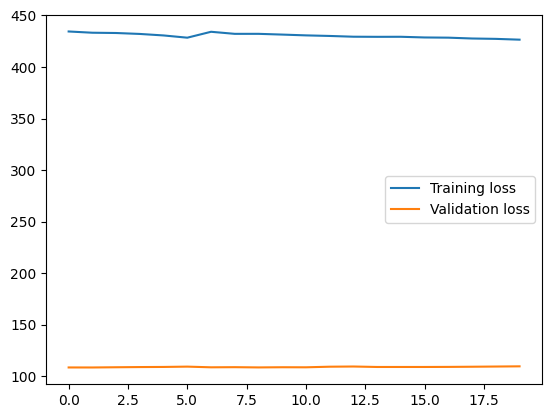

In [152]:
plt.plot(train_losses, label="Training loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()

Comme on peut le voir le modele ne semble pas converger donc c'est pas terrible on va voir ce que ca donne sur les tests.

In [155]:
def accuracy(y_pred, y_true):
    y_pred = torch.round(torch.sigmoid(y_pred))
    correct = (y_pred == y_true).float()
    acc = correct.sum() / len(correct)
    return acc

On re entraine le modele mais avec une nouvelle fonction qui va nous permettre de tracker egalement l'accuracy en plus de la loss. On va le faire sur 10 epochs car trop long sinon.

In [159]:
import copy

def train_with_accuracy(
    model: nn.Module,
    criterion: Callable,
    optimizer: torch.optim.Optimizer,
    n_epochs: int,
    train_gen: Callable,
    valid_gen: Callable,
) -> Tuple[nn.Module, List[float], List[float], List[float], List[float]]:
    """Train a model using a batch gradient descent.
    Args:
        model: a class inheriting from nn.Module.
        criterion: a loss criterion.
        optimizer: an optimizer (e.g. Adam, RMSprop, ...).
        n_epochs: the number of training epochs.
        train_gen: a callable function returing a batch (data, labels).
        valid_gen: a callable function returing a batch (data, labels).
    Returns:
        A tuple:[best_model (by validation loss), training losses, validation losses, training accuracies, validation accuracies].
    """
    best_model = None
    best_val_loss = float('inf')

    train_losses = []
    valid_losses = []

    train_accuracies = []
    valid_accuracies = []

    for epoch in range(n_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        for batch_x, batch_y in train_gen():
            batch_x, batch_y = batch_x.to(device), batch_y.to(device).unsqueeze(1).float()
            output = model(batch_x)
            loss = criterion(output, batch_y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            predictions = torch.round(torch.sigmoid(output))
            correct_predictions += (predictions == batch_y).sum().item()
            total_predictions += batch_y.size(0)

        train_losses.append(train_loss / total_predictions)
        train_accuracies.append(correct_predictions / total_predictions)

        # Validation phase
        model.eval()
        valid_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        with torch.no_grad():
            for batch_x, batch_y in valid_gen():
                batch_x, batch_y = batch_x.to(device), batch_y.to(device).unsqueeze(1).float()
                output = model(batch_x)
                loss = criterion(output, batch_y)

                valid_loss += loss.item()

                predictions = torch.round(torch.sigmoid(output))
                correct_predictions += (predictions == batch_y).sum().item()
                total_predictions += batch_y.size(0)

        valid_losses.append(valid_loss / total_predictions)
        valid_accuracies.append(correct_predictions / total_predictions)

        if valid_losses[-1] < best_val_loss:
            best_model = copy.deepcopy(model)
            best_val_loss = valid_losses[-1]

    return best_model, train_losses, valid_losses, train_accuracies, valid_accuracies


In [161]:
#train
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RNN(len(vocab), 32, 64, 1, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())
best_model, train_losses, valid_losses, train_accuracies, valid_accuracies = train_with_accuracy(model, criterion, optimizer, 10, train_gen, valid_gen)

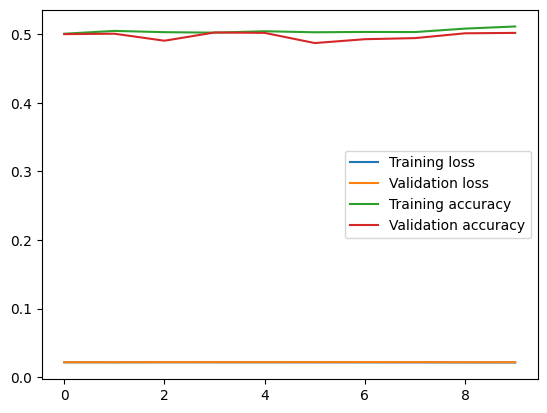

In [167]:
plt.plot(train_losses, label="Training loss")
plt.plot(valid_losses, label="Validation loss")
plt.plot(train_accuracies, label="Training accuracy")
plt.plot(valid_accuracies, label="Validation accuracy")
plt.legend()

In [164]:
def evaluate(model, criterion, test_gen):
    model.eval()
    test_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch_x, batch_y in test_gen():
            batch_x, batch_y = batch_x.to(device), batch_y.to(device).unsqueeze(1).float()
            output = model(batch_x)
            loss = criterion(output, batch_y)

            test_loss += loss.item()

            predictions = torch.round(torch.sigmoid(output))
            correct_predictions += (predictions == batch_y).sum().item()
            total_predictions += batch_y.size(0)

    return test_loss / total_predictions, correct_predictions / total_predictions

In [165]:
test_loss, test_accuracy = evaluate(best_model, criterion, test_gen)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")

Test Loss: 0.0218, Test Accuracy: 50.03%


Meme constat, le modele ne converge pas vraiment et on a une accuracy de seulement 0.5 ce qui n'est pas tres bon.

On passe maintenant au modele LSTM : 

In [168]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, n_layers, n_outputs):
        super(LSTM, self).__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_outputs = n_outputs

        self.embed = nn.Embedding(self.vocab_size, self.embed_size)
        self.lstm = nn.LSTM(self.embed_size, self.hidden_size, self.n_layers, batch_first=True)
        self.fc = nn.Linear(self.hidden_size, self.n_outputs)

    def forward(self, X):
        h0 = torch.zeros(self.n_layers, X.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.n_layers, X.size(0), self.hidden_size).to(device)

        out = self.embed(X)
        out, _ = self.lstm(out, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)

        return out


In [170]:
model = LSTM(len(vocab), 32, 64, 1, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())
best_modelLSTM, train_lossesLSTM, valid_lossesLSTM, train_accuraciesLSTM, valid_accuraciesLSTM = train_with_accuracy(model, criterion, optimizer, 10, train_gen, valid_gen)

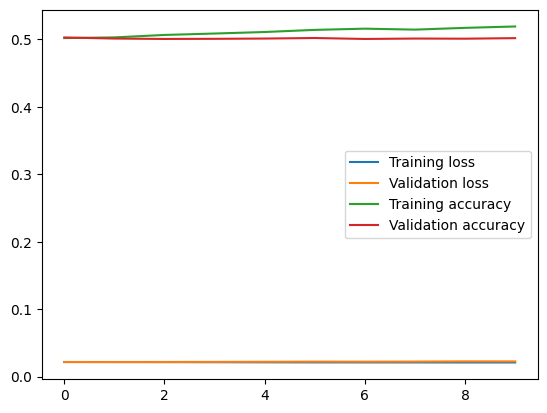

In [171]:
plt.plot(train_lossesLSTM, label="Training loss")
plt.plot(valid_lossesLSTM, label="Validation loss")
plt.plot(train_accuraciesLSTM, label="Training accuracy")
plt.plot(valid_accuraciesLSTM, label="Validation accuracy")
plt.legend()

In [172]:
test_lossLSTM, test_accuracyLSTM = evaluate(best_modelLSTM, criterion, test_gen)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")

Test Loss: 0.0218, Test Accuracy: 50.03%


Les stats sont quasiment les memes entre le RNN et le modele LSTM : 50% d'accuracy et une loss qui ne converge pas.

In [154]:
def predict_text(model, text):
    model.eval()
    with torch.no_grad():
        test_vector = text_pipeline(text).unsqueeze(0).to(device)
        output = model(test_vector)
        prediction = torch.round(torch.sigmoid(output))
        confidence = torch.sigmoid(output)
    return prediction.item(), confidence.item()

In [175]:
#test on a random text
text = "This movie is really bad. I hate it."
prediction, confidence = predict_text(best_model, text)
print(f"Prediction: {prediction}, Confidence: {confidence * 100:.2f}%")
prediction, confidence = predict_text(best_modelLSTM, text)
print(f"Prediction: {prediction}, Confidence: {confidence * 100:.2f}%")

Prediction: 1.0, Confidence: 55.33%
Prediction: 0.0, Confidence: 46.00%


Compare au lab precedent les modeles sont beaucoup moins performant et on comprend mieux l'accuracy de 50% sur les tests car sur une phrase aussi simple il n'est sur qu'a environ 50%. Le modele CNN sur Glove est beaucoup mieux.